# Multimodal RAG v2 — Describe-then-Embed

Flow:
- **Image**: Gemini describe → Jina embed teks → ChromaDB
- **PDF**: PyMuPDF extract → chunk → Jina embed teks → ChromaDB
- **Query**: Jina embed query → ChromaDB search → Gemini generate jawaban

## 1. Setup & Config

In [1]:
import os
from pathlib import Path
from IPython.display import display, Image, Markdown

from app.config import settings
from app.engine import (
    describe_image,
    extract_pdf_text,
    chunk_text,
    ingest_texts,
    query_rag,
    get_chroma_collection,
)

os.makedirs(settings.data_dir, exist_ok=True)
print(f"Data dir: {settings.data_dir}")
print(f"Chroma dir: {settings.chroma_dir}")
print(f"Collection: {settings.chroma_collection}")
print(f"Chunk size: {settings.chunk_size}, overlap: {settings.chunk_overlap}")
print("Setup done!")

Data dir: data/images
Chroma dir: storage/chroma
Collection: multimodal_rag
Chunk size: 512, overlap: 50
Setup done!


## 2. Ingest Gambar

Gambar → Gemini describe → deskripsi teks → Jina embed → ChromaDB

Describing image with Gemini...

Description:
This image compares "Document Level Retrieval" with "Subsection Level Retrieval" in Retrieval-Augmented Generation (RAG) systems.

The "Document Level Retrieval (Metrics View)" side depicts a search query leading to the retrieval of a multi-section document. A checkmark indicates that from a metrics perspective, the document is considered "Correct!" because a relevant section within it was identified.

The "Subsection Level Retrieval (Reality Check)" side shows the same document, detailing its sections: "Section 1: Intro & Overview", "Section 2: Live Chat & Support", "Section 3: Contact Information", and "Section 4: Terms & Conditions". It illustrates that while "Live Chat info" from "Section 2" might be "Retrieved", the "Needed: Phone Number" located in "Section 3: Contact Information" is missed. This results in a "Reality: Wrong Section!" outcome for the specific information required.

A concluding statement clarifies that RAG systems oft

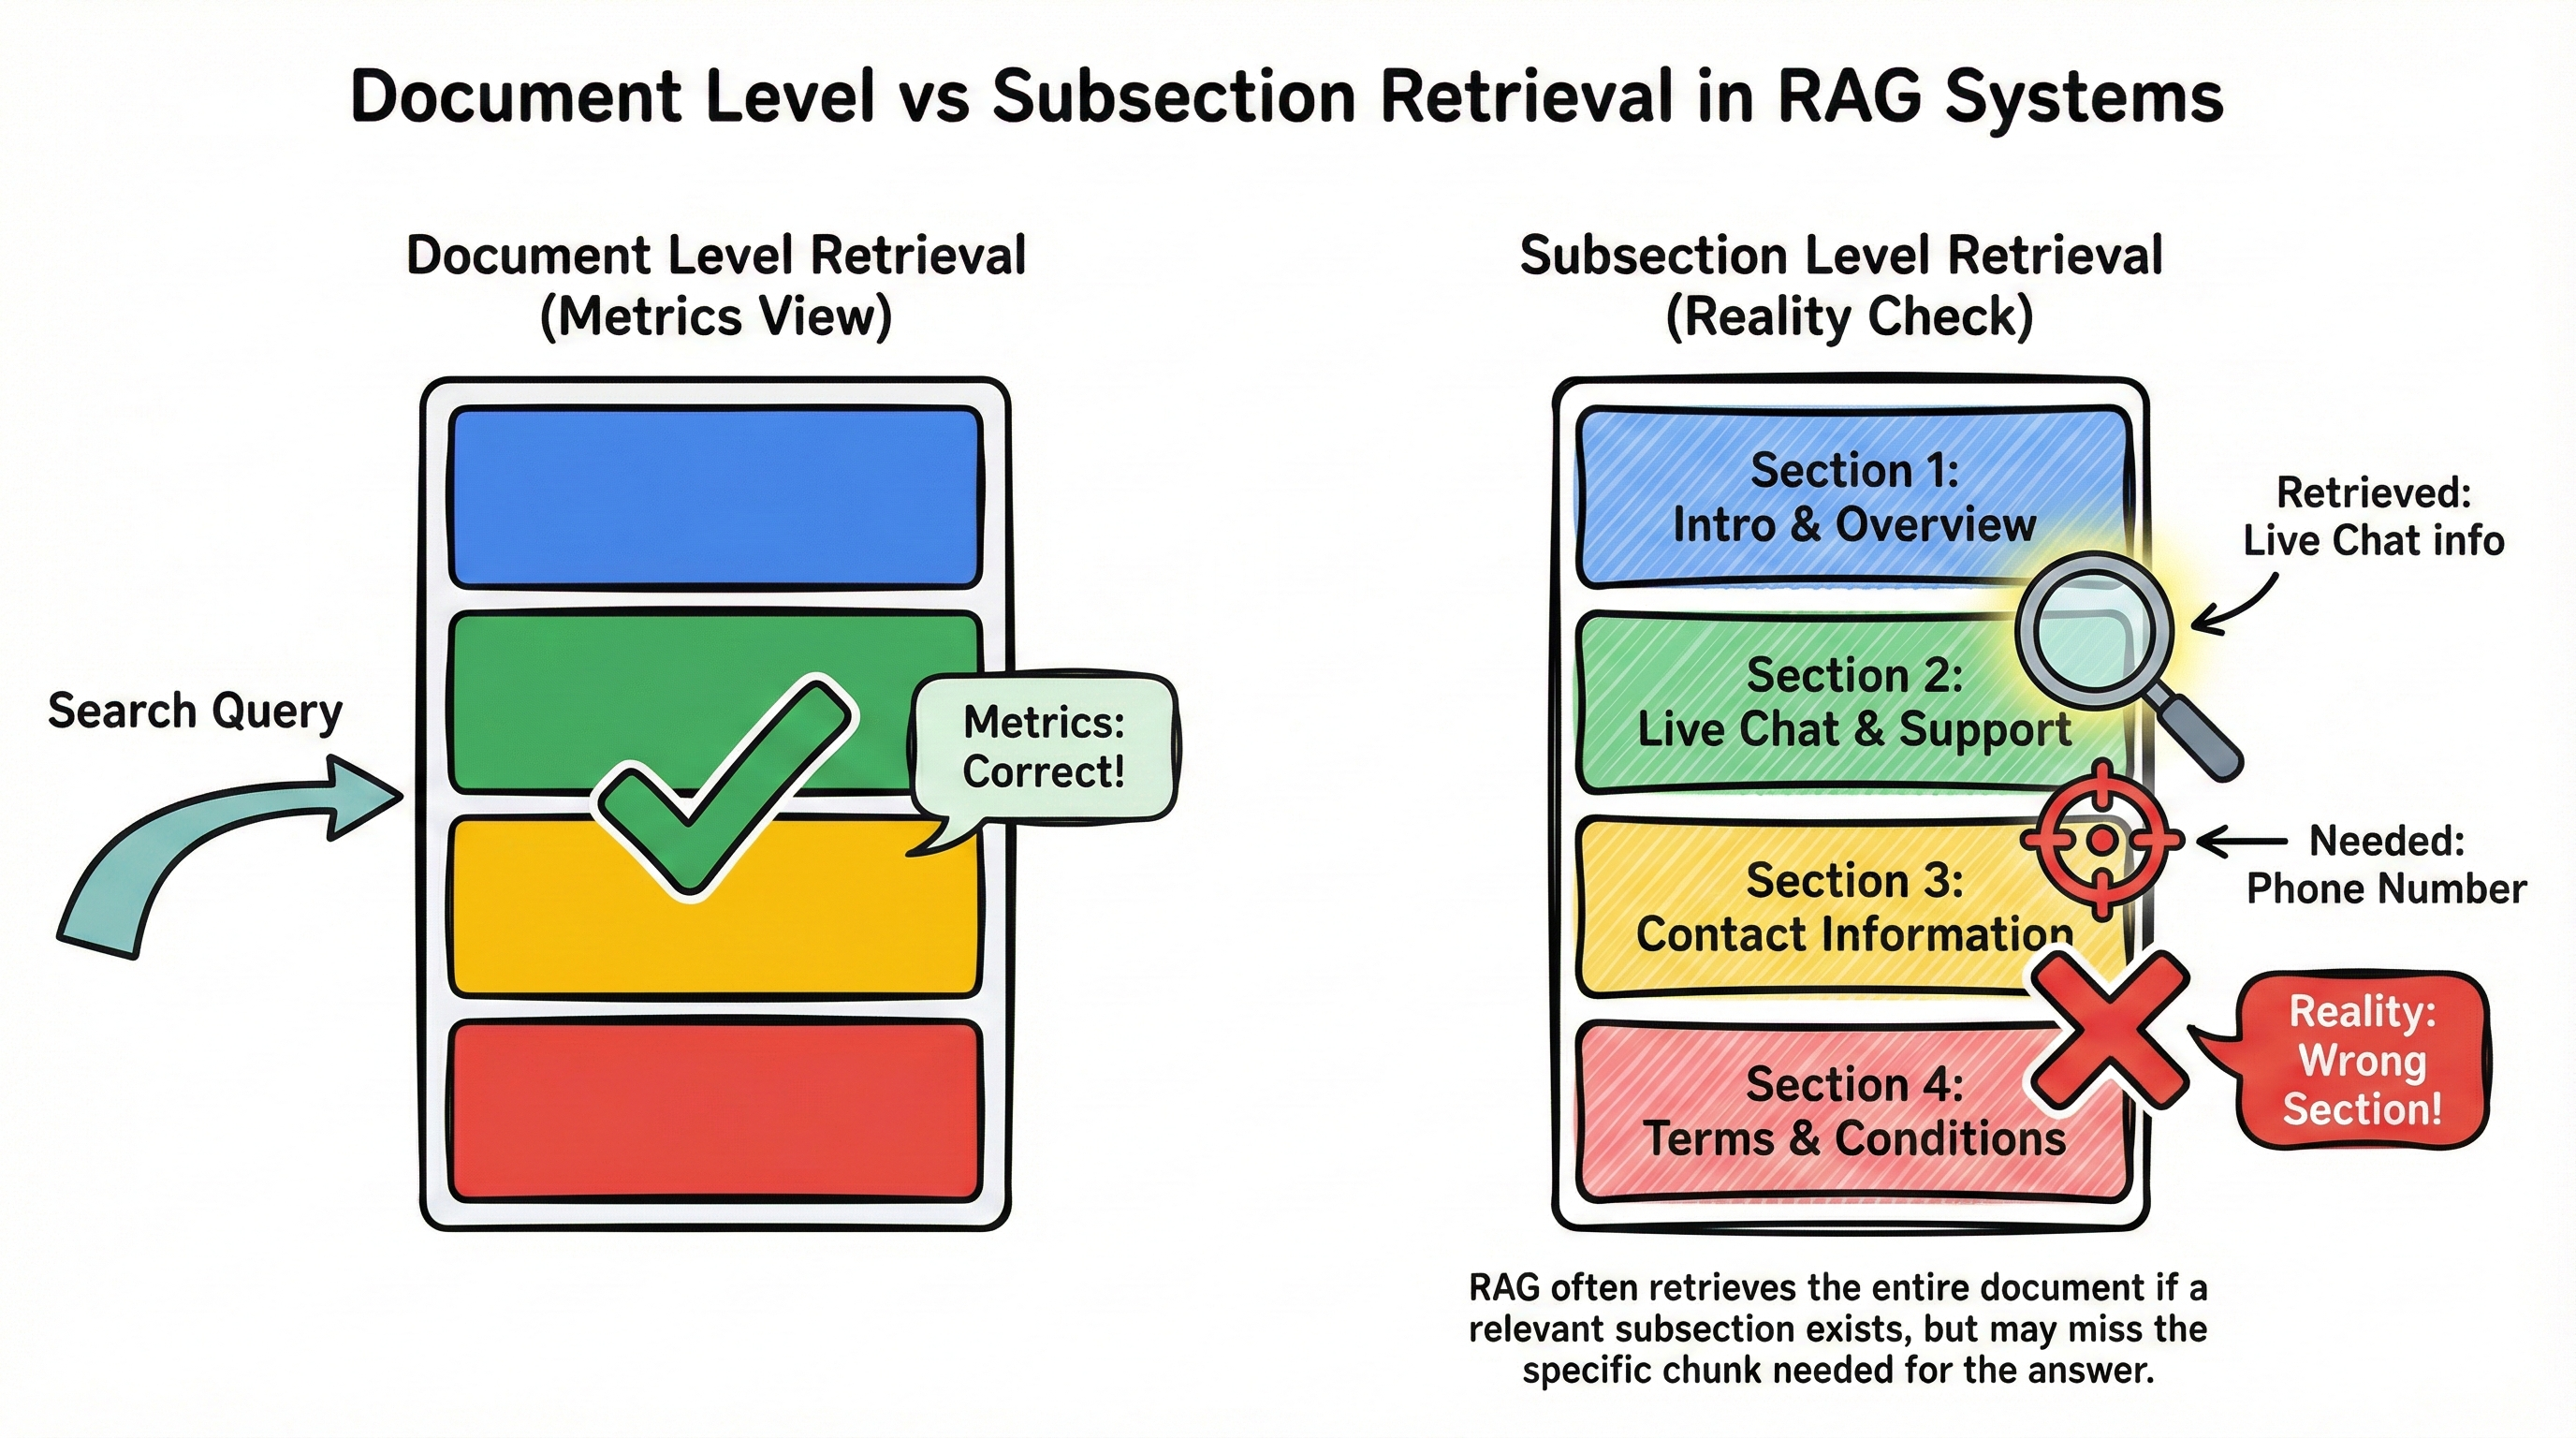

In [2]:
# Ganti path ke gambar yang mau di-ingest
IMAGE_PATH = "data/images/ae417a8b-bee7-409c-9d80-d071d849cba1.png"

# 1. Describe gambar pakai Gemini
print("Describing image with Gemini...")
description = describe_image(IMAGE_PATH)
print(f"\nDescription:\n{description}")

# 2. Preview gambar
display(Image(filename=IMAGE_PATH, width=400))

In [3]:
# 3. Embed & store deskripsi ke ChromaDB
ids = ingest_texts(
    texts=[description],
    metadatas=[{
        "source": IMAGE_PATH,
        "original_filename": Path(IMAGE_PATH).name,
        "type": "image",
    }],
)
print(f"Ingested! Node ID: {ids[0]}")

Ingested! Node ID: 07e37782-bb40-4717-b2ff-a2fb05f45b2d


## 3. Ingest PDF

PDF → PyMuPDF extract → chunk → Jina embed → ChromaDB

In [4]:
# Ganti nama file PDF yang ada di data/pdfs/
PDF_PATH = "data/pdfs/Potongan-dari-buku.pdf"

# 1. Extract teks dari PDF
print("Extracting text from PDF...")
pdf_text = extract_pdf_text(PDF_PATH)
print(f"Extracted {len(pdf_text)} characters")
print(f"\nPreview (500 chars):\n{pdf_text[:500]}")

Extracting text from PDF...
Extracted 4690 characters

Preview (500 chars):
Scaling bottlenecks 
Until now, every order of magnitude increase in model size has led to an increase in 
model performance. GPT-2 has an order of magnitude more parameters than GPT-1 
(1.5 billion versus 117 million). GPT-3 has two orders of magnitude more than 
GPT-2 (175 billion versus 1.5 billion). This means a three-orders-of-magnitude 
increase in model sizes between 2018 and 2021. Three more orders of magnitude 
growth would result in 100-trillion-parameter models.19 
How many more order


In [5]:
# 2. Chunk teks
chunks = chunk_text(pdf_text)
print(f"Total chunks: {len(chunks)}")
for i, chunk in enumerate(chunks[:3]):
    print(f"\n--- Chunk {i} ({len(chunk)} chars) ---")
    print(chunk[:200] + "...")

Total chunks: 10

--- Chunk 0 (480 chars) ---
Scaling bottlenecks 
Until now, every order of magnitude increase in model size has led to an increase in 
model performance. GPT-2 has an order of magnitude more parameters than GPT-1 
(1.5 billion v...

--- Chunk 1 (495 chars) ---
 would result in 100-trillion-parameter models.19 How many more orders of magnitude can model sizes grow? Would there be a point 
where the model performance plateaus regardless of its size? While it’...

--- Chunk 2 (537 chars) ---
 The rate of training dataset size growth is much faster than the rate of new data being generated (Villalobos et al., 2022), as illustrated 
in Figure 2-9. If you’ve ever put anything on the internet...


In [6]:
# 3. Embed & store semua chunks ke ChromaDB
pdf_name = Path(PDF_PATH).name
metadatas = [
    {
        "source": PDF_PATH,
        "original_filename": pdf_name,
        "type": "pdf",
        "chunk_index": i,
    }
    for i in range(len(chunks))
]

print(f"Ingesting {len(chunks)} chunks...")
ids = ingest_texts(texts=chunks, metadatas=metadatas)
print(f"Done! Ingested {len(ids)} chunks")
for i, node_id in enumerate(ids[:3]):
    print(f"  Chunk {i}: {node_id}")

Ingesting 10 chunks...
Done! Ingested 10 chunks
  Chunk 0: 4dbc38c9-ec80-4a98-a01f-4794b2211799
  Chunk 1: 9367e4bf-7c69-4bf8-8397-d2c2980e3954
  Chunk 2: 9e9f9b9d-e454-4961-b9ef-bfc2e85bbc5b


## 4. Query

Query → Jina embed → ChromaDB search → Gemini generate jawaban

In [7]:
QUESTION = "apa bottleneck untuk mengembangkan capabilitas model AI?"
TOP_K = 2

result = query_rag(QUESTION, top_k=TOP_K)

display(Markdown(f"### Answer\n\n{result['answer']}"))

print(f"\n--- Sources ({len(result['sources'])}) ---")
for src in result["sources"]:
    score = 1 - src['score']  # cosine distance → similarity
    print(f"  [similarity: {score:.4f}] {src['metadata'].get('original_filename', 'N/A')} ({src['metadata'].get('type', '?')})")
    print(f"           {src['text_preview'][:100]}...")

### Answer

Berdasarkan konteks yang diberikan, dua bottleneck yang terlihat untuk mengembangkan kapabilitas model AI adalah:

1.  **Data pelatihan (Training data)**: Ada kekhawatiran realistis bahwa kita akan kehabisan data internet dalam beberapa tahun ke depan karena model-model dasar menggunakan begitu banyak data. Setelah data publik habis, jalur yang paling mungkin untuk mendapatkan lebih banyak data pelatihan buatan manusia adalah melalui data *proprietary* yang unik (seperti buku berhak cipta, terjemahan, kontrak, rekam medis, urutan genom, dll.), yang akan menjadi keuntungan kompetitif.
2.  **Listrik (Electricity)**.


--- Sources (2) ---
  [similarity: 0.6476] Potongan-dari-buku.pdf (pdf)
            would result in 100-trillion-parameter models.19 How many more orders of magnitude can model sizes ...
  [similarity: 0.6372] Potongan-dari-buku.pdf (pdf)
           umailov et al., 2023). However, the impact of AI- generated data on models is more nuanced and is di...


## 5. Utils

List dokumen, hapus, reset DB

In [8]:
# List semua dokumen di ChromaDB
collection = get_chroma_collection()
data = collection.get()

print(f"Total documents: {len(data['ids'])}")
for i, (doc_id, meta) in enumerate(zip(data["ids"], data["metadatas"])):
    print(f"  {i}. [{doc_id[:8]}...] {meta.get('original_filename', 'N/A')} ({meta.get('type', '?')})")

Total documents: 11
  0. [07e37782...] ae417a8b-bee7-409c-9d80-d071d849cba1.png (image)
  1. [4dbc38c9...] Potongan-dari-buku.pdf (pdf)
  2. [9367e4bf...] Potongan-dari-buku.pdf (pdf)
  3. [9e9f9b9d...] Potongan-dari-buku.pdf (pdf)
  4. [e4e72a8d...] Potongan-dari-buku.pdf (pdf)
  5. [6b3d1ad2...] Potongan-dari-buku.pdf (pdf)
  6. [a2f571e3...] Potongan-dari-buku.pdf (pdf)
  7. [1234ea1c...] Potongan-dari-buku.pdf (pdf)
  8. [d5c02b54...] Potongan-dari-buku.pdf (pdf)
  9. [b527ba78...] Potongan-dari-buku.pdf (pdf)
  10. [1f83293e...] Potongan-dari-buku.pdf (pdf)


In [ ]:
# Hapus dokumen by ID
# DELETE_IDS = ["id-to-delete"]
# collection = get_chroma_collection()
# collection.delete(ids=DELETE_IDS)
# print(f"Deleted {len(DELETE_IDS)} documents")

In [ ]:
# Reset: hapus semua data di collection
import chromadb
client = chromadb.PersistentClient(path=settings.chroma_dir)
client.delete_collection(settings.chroma_collection)
print("Collection deleted. Run setup cell again to recreate.")